In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:    
    !pip install bpemb
    !pip install git+https://github.com/kmike/pymorphy2.git pymorphy2-dicts-uk

import os
if not os.path.isdir('data'):
    os.mkdir('data')

In [82]:
import pandas as pd
import numpy as np
from typing import List
%matplotlib inline
import matplotlib.pyplot as plt

# Download CSV files

In [3]:
df_learn = pd.read_csv('data/rozetka_learn.csv')
df_test = pd.read_csv('data/rozetka_test.csv')

# Look on the data

In [4]:
print(f"Learn set shape: {df_learn.shape}")
print(f"Test set shape: {df_test.shape}")

Learn set shape: (3800, 5)
Test set shape: (1629, 5)


In [5]:
df_learn.head()

,goods_code,stars,review,author,permalink
0,13252316,1,Шановні! Де обіцяна знижка 5% при оплаті карто...,Андрей Дмитриев,#tab=comments;id=34200034
1,61270053,5,"Дизайн зайде не кожному, но є аналог Xiaomi Re...",Виталий Александрович,#tab=comments;id=35938497
2,45499672,5,колір тільки синій чи чорний теж є?,Арт Лаз,#tab=comments;id=30229184
3,48116526,4,"Швидкий та зручний телефон, має презентабельни...",Дима Лисунов,#tab=comments;id=36726816
4,55379058,5,Купувався мамі на подарунок. Дуже задоволена. ...,Микола,#tab=comments;id=38966133


In [6]:
df_learn.groupby('stars').count()

,goods_code,review,author,permalink
stars,,,,
1,173,173,173,173
2,122,122,122,122
3,222,222,222,222
4,746,746,746,746
5,2537,2537,2537,2537


In [7]:
df_test.groupby('stars').count()

,goods_code,review,author,permalink
stars,,,,
1,93,93,93,93
2,59,59,59,59
3,101,101,101,101
4,316,316,316,316
5,1060,1060,1060,1060


# Sentiment analizer - baseline

In [8]:
def stars_to_sentiment(stars):
    res = []
    for s in stars:
        if s<3:
            res.append('neg')
        elif s<5:
            res.append('ind') # indifferent
        else:
            res.append('pos')
    return res

def find_classes(label: str, sentiments: List[str])->List[bool]:
    return [s==label for s in sentiments]

print(stars_to_sentiment([1,2,3,4,5]))
print(find_classes('ind', stars_to_sentiment([1,2,3,4,5])))

['neg', 'neg', 'ind', 'ind', 'pos']
[False, False, True, True, False]


In [9]:
X_learn = df_learn['review'].values
X_test = df_test['review'].values
y_learn = stars_to_sentiment(df_learn['stars'].values)
y_test = stars_to_sentiment(df_test['stars'].values)

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import SGDClassifier

In [11]:
UK_STOP_WORDS = set(
    """
а або адже аж але алло 
б багато без безперервно би більш більше біля близько бо був буває буде будемо
будете будеш буду будуть будь була були було бути 
в вам вами вас ваш ваша ваше вашим вашими ваших ваші вашій вашого вашої вашому
вашою вашу вгорі вгору вдалині весь вже ви від відсотків він вісім вісімнадцятий
вісімнадцять вниз внизу вона вони воно восьмий все всею всі всім всіх всього
всьому всю вся втім
г геть говорив говорить 
давно далеко далі дарма два двадцятий двадцять дванадцятий дванадцять дві двох
де дев'ятий дев'ятнадцятий дев'ятнадцять дев'ять декілька день десятий десять
дійсно для дня до добре довго доки досить другий дуже дякую
е
є
ж же
з за завжди зазвичай занадто зараз зате звичайно звідси звідусіль здається
зі значить знову зовсім
і із іноді інша інше інший інших інші
її їй їм їх
й його йому
каже ким кілька кого кожен кожна кожне кожні коли кому краще крім куди 
ласка ледве лише
м має майже мало мати мене мені менш менше ми мимо міг між мій мільйонів мною
мого могти моє моєї моєму моєю може можна можно можуть мої моїй моїм моїми моїх
мою моя
на навіть навіщо навколо навкруги нагорі над назад найбільш нам нами нарешті нас
наш наша наше нашим нашими наших наші нашій нашого нашої нашому нашою нашу не
небагато небудь недалеко неї немає нерідко нещодавно нею нибудь нижче низько ним
ними них ні ніби ніж ній ніколи нікуди нім нічого ну нього ньому
о обидва обоє один одинадцятий одинадцять однак однієї одній одного означає
окрім он особливо ось
п'ятий п'ятнадцятий п'ятнадцять п'ять перед перший під пізніше пір після по 
повинно подів поки пора поруч посеред потім потрібно почала початку при про 
просто проте проти 
раз разу раніше рано раптом рік роки років року році
сам сама саме самим самими самих самі самій само самого самому саму свого своє
своєї свої своїй своїх свою себе сих сім сімнадцятий сімнадцять сказав сказала
сказати скільки скрізь собі собою спасибі спочатку справ став суть сьогодні 
сьомий 
т та так така таке такий такі також там твій твого твоє твоєї твоєму твоєю твої
твоїй твоїм твоїми твоїх твою твоя те тебе теж тепер ти тим тими тисяч тих ті
тієї тією тій тільки тім то тобі тобою того тоді той тому тою треба третій три
тринадцятий тринадцять трохи ту туди тут 
у увесь уміти усе усі усім усіма усіх усього усьому усю усюди уся 
хіба хотіти хоч хоча хочеш хто
це цей цим цими цих ці цієї цій цього цьому цю ця 
час частіше часто часу через четвертий чи чиє чиєї чиєму чиї чиїй чиїм чиїми 
чиїх чий чийого чийому чим численна численне численний численні чию чия чого
чому чотири чотирнадцятий чотирнадцять
шістнадцятий шістнадцять шість шостий
ще що щоб щодо щось 
я як яка який яких які якій якого якої якщо""".split()
)

print(list(UK_STOP_WORDS)[:10])

['говорить', 'ним', 'моє', 'нас', 'посеред', 'біля', "дев'ятнадцять", 'буде', 'лише', 'наших']


In [12]:
# pip install git+https://github.com/kmike/pymorphy2.git pymorphy2-dicts-uk
import pymorphy2
morph = pymorphy2.MorphAnalyzer(lang='uk')
norm = morph.parse('таку')[0].normal_form
print(norm)

print(list(UK_STOP_WORDS)[:10])



такий
['говорить', 'ним', 'моє', 'нас', 'посеред', 'біля', "дев'ятнадцять", 'буде', 'лише', 'наших']


In [13]:
from nltk import word_tokenize

def tokenize_lemmatize_filter(text: str, trace: False)->List[str]:
    if trace:
        print(text)
    tokens = word_tokenize(text)
    if trace:
        print(tokens)
    #tokens = [t for t in tokens if t.lower() not in UK_STOP_WORDS]
    #tokens = [t for t in tokens if t.isalpha()]
    if trace:
        print(tokens)
    result = [morph.parse(t)[0].normal_form for t in tokens]
    if trace:
        print(result)
    return result

In [14]:
tokenize_lemmatize_filter(X_learn[0], trace=True)

Шановні! Де обіцяна знижка 5% при оплаті картою МастерКард? Раніше була а тепер зникла. Перевірте будь ласка - коли додаєш товар у кошик і обираєш "Акція! Знижка 5% при оплаті карткою Mastercard через Masterpass!" то ціна не змінюється.
['Шановні', '!', 'Де', 'обіцяна', 'знижка', '5', '%', 'при', 'оплаті', 'картою', 'МастерКард', '?', 'Раніше', 'була', 'а', 'тепер', 'зникла', '.', 'Перевірте', 'будь', 'ласка', '-', 'коли', 'додаєш', 'товар', 'у', 'кошик', 'і', 'обираєш', '``', 'Акція', '!', 'Знижка', '5', '%', 'при', 'оплаті', 'карткою', 'Mastercard', 'через', 'Masterpass', '!', "''", 'то', 'ціна', 'не', 'змінюється', '.']
['Шановні', '!', 'Де', 'обіцяна', 'знижка', '5', '%', 'при', 'оплаті', 'картою', 'МастерКард', '?', 'Раніше', 'була', 'а', 'тепер', 'зникла', '.', 'Перевірте', 'будь', 'ласка', '-', 'коли', 'додаєш', 'товар', 'у', 'кошик', 'і', 'обираєш', '``', 'Акція', '!', 'Знижка', '5', '%', 'при', 'оплаті', 'карткою', 'Mastercard', 'через', 'Masterpass', '!', "''", 'то', 'ціна', 

['шановний',
 '!',
 'де',
 'обіцяний',
 'знижка',
 '5',
 '%',
 'перти',
 'оплата',
 'карта',
 'мастеркард',
 '?',
 'раніший',
 'булий',
 'а',
 'тепер',
 'зниклий',
 '.',
 'перевірити',
 'бути',
 'ласка',
 '-',
 'коли',
 'додавати',
 'товар',
 'у',
 'кошик',
 'і',
 'обирати',
 '``',
 'акція',
 '!',
 'знижка',
 '5',
 '%',
 'перти',
 'оплата',
 'картка',
 'mastercard',
 'через',
 'masterpass',
 '!',
 "''",
 'то',
 'ціна',
 'не',
 'змінюватися',
 '.']

In [15]:
def show_most_freq_terms(features, vocab):
    # https://medium.com/@cristhianboujon/how-to-list-the-most-common-words-from-text-corpus-using-scikit-learn-dad4d0cab41d
    sum_words = features.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vocab.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    print(words_freq[:100])

def classifier_nb_tfidf(X_learn, y_learn, X_test, y_test, 
                        trace = False):
    def tokenizer(text):
        return tokenize_lemmatize_filter(text, trace=False)
    featurizer = CountVectorizer(
        tokenizer=tokenizer,
        min_df = 10, max_df = 0.1
                    ) 
    features_learn = featurizer.fit_transform(X_learn)
    if trace:
        show_most_freq_terms(features_learn, featurizer.vocabulary_)
    features_test = featurizer.transform(X_test)
    if trace:
        print(f"Dictionary size = {len(featurizer.vocabulary_)}")
        #print(sorted([(v, k) for k, v in featurizer.vocabulary_.items()], reverse=True)[:100])
    clf = BernoulliNB() # SGDClassifier()
    clf.fit(features_learn, y_learn)
    y_predicted = clf.predict(features_test)
    return y_predicted

In [16]:
from sklearn import metrics
from scipy import stats

def show_metrics_one_label(label: str, y_pred: List[bool], y_test: List[bool]):
    print(f'Metrics for {label}:')
    # print(y_pred[:20])
    # print(y_test[:20])
    print(f"  Accuracy:  {metrics.accuracy_score(y_test, y_pred)}")
    print(f"  Precision: {metrics.precision_score(y_test, y_pred)}")
    print(f"  Recall:    {metrics.recall_score(y_test, y_pred)}")
    f1 = metrics.f1_score(y_test, y_pred)
    print(f"  F1:        {f1}")
    return f1

def harmonic_mean_f1(y_pred: List[str], y_test: List[str])->float:
    f1 = metrics.f1_score(y_test, y_pred)
    hmean_f1 = stats.hmean(f1)
    
def show_metrics(y_pred: List[str], y_test: List[str]):
    f1s = []
    for label in ['neg', 'ind', 'pos']:
        f1s.append(show_metrics_one_label(label, find_classes(label, y_pred), find_classes(label, y_test)))
    print(f"Mean F1 = {np.mean(f1s)}")



In [17]:
predictions = classifier_nb_tfidf(X_learn, y_learn, X_test, y_test, trace=True)
show_metrics(list(predictions), list(y_test))


[('смартфон', 492), (':', 476), ("''", 471), ('то', 463), ('...', 449), ('ще', 421), ('без', 414), ('від', 412), ('просто', 404), ('йога', 399), ('``', 393), ('можна', 391), ('проблема', 383), ('той', 381), ('якщо', 380), ('після', 372), ('один', 371), ('том', 367), ('через', 360), ('час', 357), ('2', 357), ('розетка', 355), ('чудовий', 339), ('швидко', 335), ('супер', 327), ('звук', 325), ('тримати', 321), ('коли', 315), ('даний', 315), ('користування', 314), ('скло', 313), ('якість', 312), ('мати', 311), ('немає', 309), ('модель', 306), ('добре', 301), ('навіть', 297), ('тільки', 296), ('інший', 294), ('два', 291), ('доставка', 290), ('мій', 288), ('рекомендувати', 287), ('фото', 283), ('раз', 283), ('прийти', 276), ('рука', 270), ('робот', 264), ('швидкий', 261), ('тиждень', 260), ('гріш', 256), ('про', 255), ('перший', 255), ('тут', 249), ('також', 244), ('гарний', 241), ('чохол', 235), ('дніти', 235), ('купувати', 234), ('дно', 232), ('дякувати', 230), ('%', 228), ('більше', 228),

Я трохи погрався із параметрами, серед яких:

* Чи відфільтровувати стоп-слова
* Чи відфільтровувати токени з "небуквами"
* Параметри min_df та max_df в CountVectorizer

Найкраще значення гармонічного середнього F1 одержано при таких параметрах:

Не відфільтровуємо стоп-слова та пропускаємо всі типи токенів

min_df = 10, max_df = 0.15

Mean F1 = 0.49569680981519443

# CNN

In [18]:
from bpemb import BPEmb

In [19]:
emb = BPEmb(lang='uk', dim=300)

In [20]:
e = emb.embed('словотворення, сполучники')
print(e.shape)

(7, 300)


In [21]:
def uk_embed(text: str, trace: bool=False)->List[str]:
    if trace:
        print(text)
    e = emb.embed(text.casefold())
    if trace:
        print(e.shape)
    return e

uk_embed('Цікаво, що нам дасть цей спосіб ембедінга?', True)

Цікаво, що нам дасть цей спосіб ембедінга?
(15, 300)


array([[ 0.18526 ,  0.020145,  0.18307 , ...,  0.066738,  0.223291,
         0.25658 ],
       [ 0.252238,  0.023855, -0.019895, ...,  0.228245, -0.313883,
         0.168077],
       [-0.024104,  0.387407, -0.22626 , ...,  0.196852,  0.102134,
        -0.206396],
       ...,
       [ 0.207108,  0.306064,  0.135806, ..., -0.373194,  0.666558,
        -0.238359],
       [ 0.087427, -0.224826, -0.151333, ...,  0.034885, -0.172667,
         0.032706],
       [ 0.13943 ,  0.008205, -0.025675, ..., -0.110246,  0.33713 ,
         0.371534]], dtype=float32)

In [23]:
maxlen = 500 

print(X_learn[0], y_learn[0])
X_learn_embs = [uk_embed(x) for x in X_learn]
X_test_embs = [uk_embed(x) for x in X_test]
print(len(X_learn_embs))

Шановні! Де обіцяна знижка 5% при оплаті картою МастерКард? Раніше була а тепер зникла. Перевірте будь ласка - коли додаєш товар у кошик і обираєш "Акція! Знижка 5% при оплаті карткою Mastercard через Masterpass!" то ціна не змінюється. neg
3800


In [68]:
def pad_seq(embs, maxlen):
    total_samples = embs.shape[0]
    res = np.zeros(shape=(total_samples, maxlen, dim))
    for sample in range(total_samples):
        smp = embs[sample]
        for token_num in range(maxlen):
            leave_pad = smp.shape[0]<=token_num
            if not leave_pad:
                res[sample, token_num, :] = smp[token_num,:]
    return res

print()

In [69]:
from keras.preprocessing import sequence

print('Pad sequences (samples x time x embeddings)')
input_train = sequence.pad_sequences(X_learn_embs, maxlen=maxlen)
input_test = sequence.pad_sequences(X_test_embs, maxlen=maxlen)
print('input_train shape:', input_train.shape, input_train.dtype)
print('input_test shape:', input_test.shape, input_test.dtype)
print(X_learn_embs[0].shape)


Pad sequences (samples x time x embeddings)
X_learn_embs shape: (3800, 500, 300) int32
X_test_embs shape: (1629, 500, 300) int32
(84, 300)


In [57]:
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

label_encoder = LabelEncoder()
y_learn_enc = label_encoder.fit_transform(y_learn)
y_test_enc = label_encoder.transform(y_test)

y_learn_enc = y_learn_enc.reshape(len(y_learn_enc), 1)
y_test_enc = y_test_enc.reshape(len(y_test_enc), 1)

one_hot_encoder = OneHotEncoder(sparse=False)
y_learn_one_hot = one_hot_encoder.fit_transform(y_learn_enc)
y_test_one_hot = one_hot_encoder.transform(y_test_enc)

print(y_learn_one_hot)


[[0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 ...
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]]


C:\Users\ssotn\Anaconda3\envs\nlp\lib\site-packages\sklearn\preprocessing\_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


X_learn_embs = np.array(X_learn_embs)
X_test_embs = np.array(X_test_embs)
y_learn_one_hot = np.array(y_learn_one_hot)
y_test_one_hot = np.array(y_test_one_hot)
print('X_learn_embs shape:', X_learn_embs.shape, X_learn_embs.dtype)
print('X_test_embs shape:', X_test_embs.shape, X_test_embs.dtype)

In [54]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras import regularizers

In [91]:
l2 = 0.001
dout = 0.1
max_features = 300

model = Sequential()
#model.add(layers.Embedding(max_features, 64, input_length=maxlen, embeddings_regularizer=regularizers.l2(l2)))
#model.add(layers.Dropout(dout))
model.add(layers.Conv1D(61, 7, activation='relu', input_shape=(500,300),
                        kernel_regularizer=regularizers.l2(l2)))
model.add(layers.MaxPooling1D(5))
model.add(layers.Dropout(dout))
model.add(layers.Conv1D(32, 7, activation='relu', kernel_regularizer=regularizers.l2(l2)))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dropout(dout))
model.add(layers.Dense(3, activation='softmax', kernel_regularizer=regularizers.l2(l2)))

model.compile(optimizer=Adam(lr=1e-3),
                #loss='binary_crossentropy',
                #loss='mean_squared_error',
                loss='categorical_crossentropy',
                metrics=['acc'])

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_33 (Conv1D)           (None, 494, 61)           128161    
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 98, 61)            0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 98, 61)            0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 92, 32)            13696     
_________________________________________________________________
global_max_pooling1d_16 (Glo (None, 32)                0         
_________________________________________________________________
dropout_32 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 3)                 99        
Total para

In [92]:
early_stopping=EarlyStopping(monitor='val_acc', patience=15)
reduce_lr = ReduceLROnPlateau(monitor='acc', factor=0.2,
                              patience=5, min_lr=0.000001,
                              verbose=True)
checkpoint = ModelCheckpoint('data/r.weights.cnn.best.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')


history = model.fit(input_train, y_learn_one_hot,
            epochs=100,
            batch_size=16,
            validation_split=0.2,
            callbacks=[early_stopping, reduce_lr, checkpoint])

Train on 3040 samples, validate on 760 samples
Epoch 1/100
3040/3040 [==============================] - 32s 11ms/step - loss: 0.9202 - acc: 0.6668 - val_loss: 0.8850 - val_acc: 0.6671

Epoch 00001: val_acc improved from -inf to 0.66711, saving model to data/r.weights.cnn.best.hdf5
Epoch 2/100
3040/3040 [==============================] - 32s 11ms/step - loss: 0.8496 - acc: 0.6678 - val_loss: 0.8659 - val_acc: 0.6671

Epoch 00002: val_acc did not improve from 0.66711
Epoch 3/100
3040/3040 [==============================] - 32s 11ms/step - loss: 0.8266 - acc: 0.6684 - val_loss: 0.8633 - val_acc: 0.6737

Epoch 00003: val_acc improved from 0.66711 to 0.67368, saving model to data/r.weights.cnn.best.hdf5
Epoch 4/100
3040/3040 [==============================] - 32s 11ms/step - loss: 0.8095 - acc: 0.6707 - val_loss: 0.8672 - val_acc: 0.6684

Epoch 00004: val_acc did not improve from 0.67368
Epoch 5/100
3040/3040 [==============================] - 32s 11ms/step - loss: 0.7888 - acc: 0.6803 - va

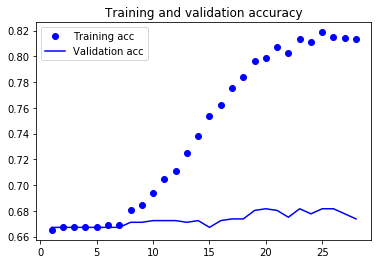

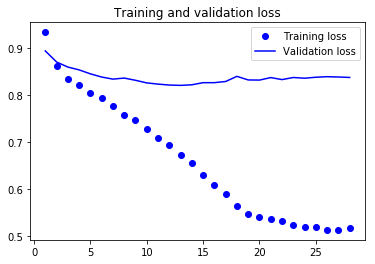

In [83]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()